<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Optimization Visualization</center><h2>
<h3><center>Neisarg Dave</center><h3>

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
matplotlib.rc('font', size=16)

### Preparing Data:

Lets create equally spaced 10 data points  $(x_i, y_i)$ such that $x_i \in [0, 1]$ and $y_i = 1$ if $x > 0.5$ else $y_i = 0$

In [2]:
x = np.arange(0, 1, 0.1)
_y = np.round(x)
print(x)
print(_y)
_y = np.expand_dims(_y,  axis = -1)
y = np.expand_dims(_y,  axis = -1)
print(x.shape, y.shape)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
(10,) (10, 1, 1)


### Activation, Loss and other helper functions

In [3]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def relu(x):
  mask = x >= 0
  return mask*x

In [4]:
def mse_loss(y_hat, y):
  return (y_hat - y)**2

def ce_loss(y_hat, y):
  return -(np.multiply(y,np.log(y_hat + 1e-4)) + np.multiply((1-y), np.log(1-y_hat + 1e-4)))


### Optimization Curves for an Affine Transformation

Lets consider the transformation:
$$
  f = wx + b
$$

$$
  \hat y = σ(f(w, x, b))
$$

And look at the optimization curves of w.r.t **mse** and and **cross entropy** loss functions on the given data set with affine transformation

In [5]:
class AffineLayer:
  def forward(self, w, b, x):
    x = np.expand_dims(x, axis=-1)
    f = np.matmul(x,  w)
    f = np.expand_dims(f, axis = -1)
    f = f + b.reshape(1, 1, b.shape[0])
    return f

  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)

In [6]:
w = np.arange(-20, 20, 0.01).reshape(1, 4000)
b = np.arange(-20, 20, 0.01)

model = AffineLayer()
y_hat = sigmoid(model(w, b, x))
print(y_hat.shape)

(10, 4000, 4000)


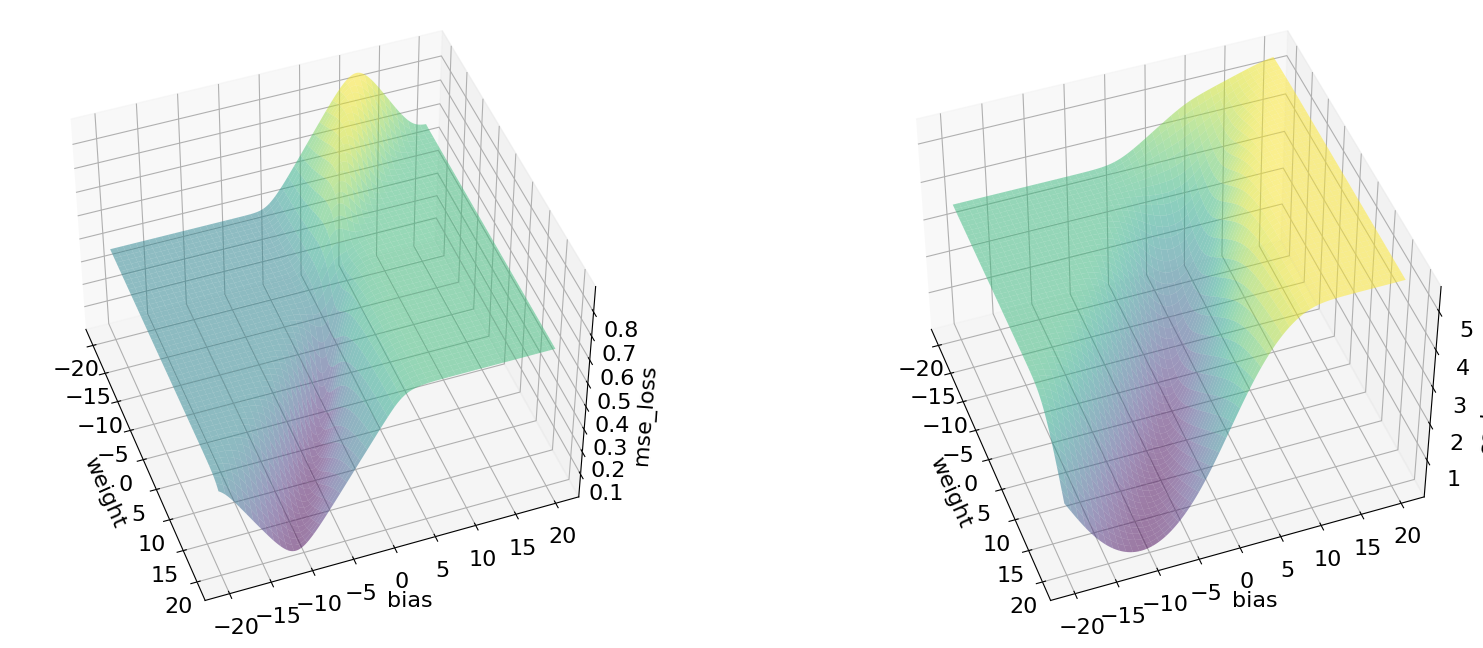

In [7]:
mse_curve = np.mean(mse_loss(y_hat, y), axis=0).transpose()
ce_curve = np.mean(ce_loss(y_hat, y), axis = 0).transpose()

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')

W, B = np.meshgrid(w.squeeze(), b.squeeze())

ax1.plot_surface(W, B, mse_curve, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("weight")
ax1.set_ylabel("bias")
ax1.set_zlabel("mse_loss")
ax1.view_init(45, -20)

ax2.plot_surface(W, B, ce_curve, cmap='viridis', alpha = 0.5)
ax2.set_xlabel("weight")
ax2.set_ylabel("bias")
ax2.set_zlabel("ce_loss")
ax2.view_init(45, -20)

plt.show()

## 2 Parameter - 2 Layer Neural Network

Now consider a 2-layer neural network s.t.:
$$
  z = w_1x \\
  f = w_2z
$$

$$
  \hat y = σ(f(w_1, w_2, x))
$$

In [8]:
class LinearLayer:
  def forward(self, w, x):
    self.ctx = {"w" : w, "x" : x}
    x = np.expand_dims(x, axis=-1)
    f = np.matmul(x,  w)
    return f

  def backward(self, grad_output):
    w, x = self.ctx["w"], self.ctx["x"]
    grad_w = grad_output * x
    grad_x = grad_output * w

    return grad_w, grad_x

  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)

In [9]:
class TwoParameterNN:
  def __init__(self, act=None):
    self.l1 = LinearLayer()
    self.l2 = LinearLayer()
    self.act_fn = act

  def forward(self, w1, w2, x):
    z = self.l1(w1, x)
    if self.act_fn is not None:
      z = self.act_fn(z)
    f = self.l2(w2, z)
    return f

  # def backward(self, grad_output):
  #   dl_dw2, dl_dz = self.l2.backward(grad_output)
  #   dl_dw1, dl_dx = self.l1.backward(dl_dz)
  #   return dl_dw2, dl_dw1, dl_dx

  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)

In [10]:
w1 = np.arange(-10, 10, 0.01).reshape(1, 2000)
w2 = np.arange(-10, 10, 0.01).reshape(1, 2000)

model = TwoParameterNN()
y_hat = sigmoid(model(w1, w2, x))
print(y_hat.shape)

(10, 2000, 2000)


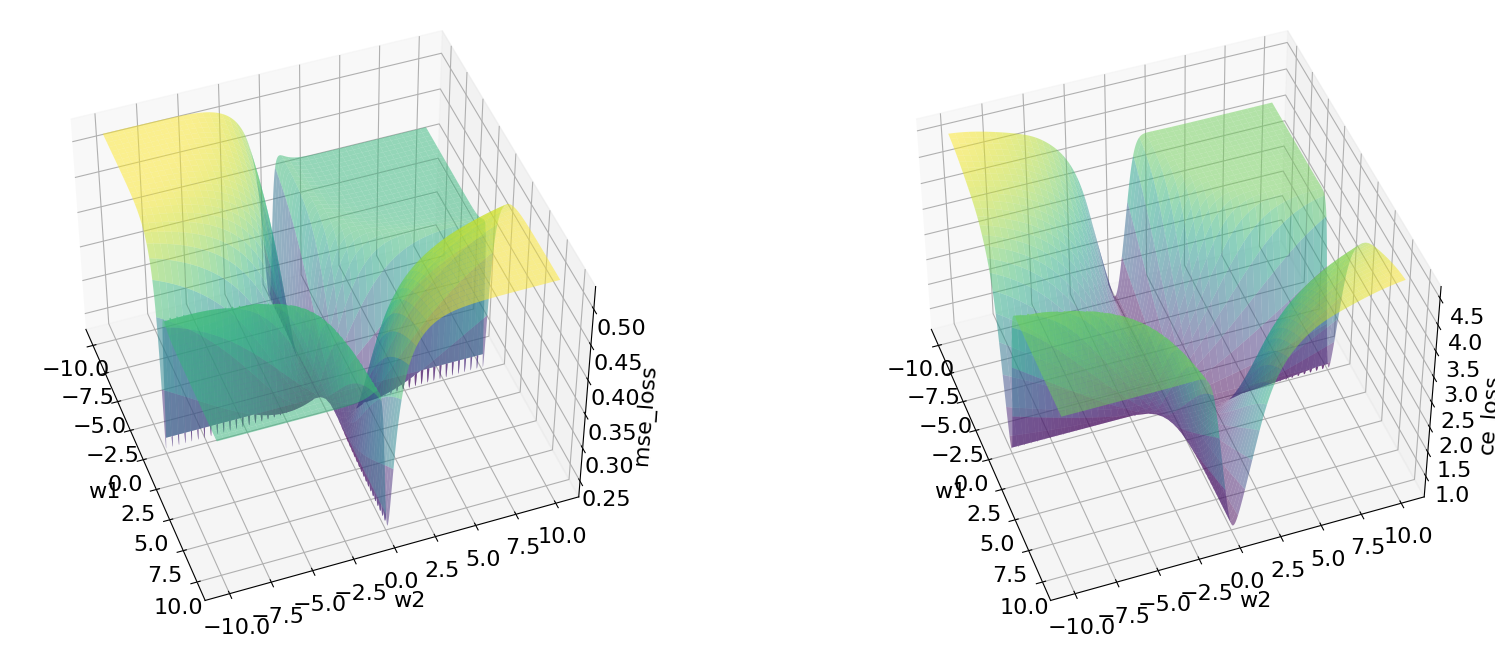

In [11]:
# plot the surface
mse_curve = np.mean(mse_loss(y_hat, y), axis=0).transpose()
ce_curve = np.mean(ce_loss(y_hat, y), axis = 0).transpose()

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')

W1, W2 = np.meshgrid(w1.squeeze(), w2.squeeze())

ax1.plot_surface(W1, W2, mse_curve, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("mse_loss")
ax1.view_init(45, -20)

ax2.plot_surface(W1, W2, ce_curve, cmap='viridis', alpha = 0.5)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("ce_loss")
ax2.view_init(45, -20)

plt.show()


In [12]:
print( np.min(mse_curve))

0.23188799582697106


### Neural Network with activation functions

Lets consider the following activation functions:
1. ReLU: $z = relu(w_1x)$
2. Sigmoid: $z = \sigma(w_1x)$
3. Tanh: $z = tanh(w_1x)$

$$
  f = w_2z \\
  \hat y = \sigma(f(w_1, w_2, x))
$$

**ReLU**

(10, 2000, 2000)


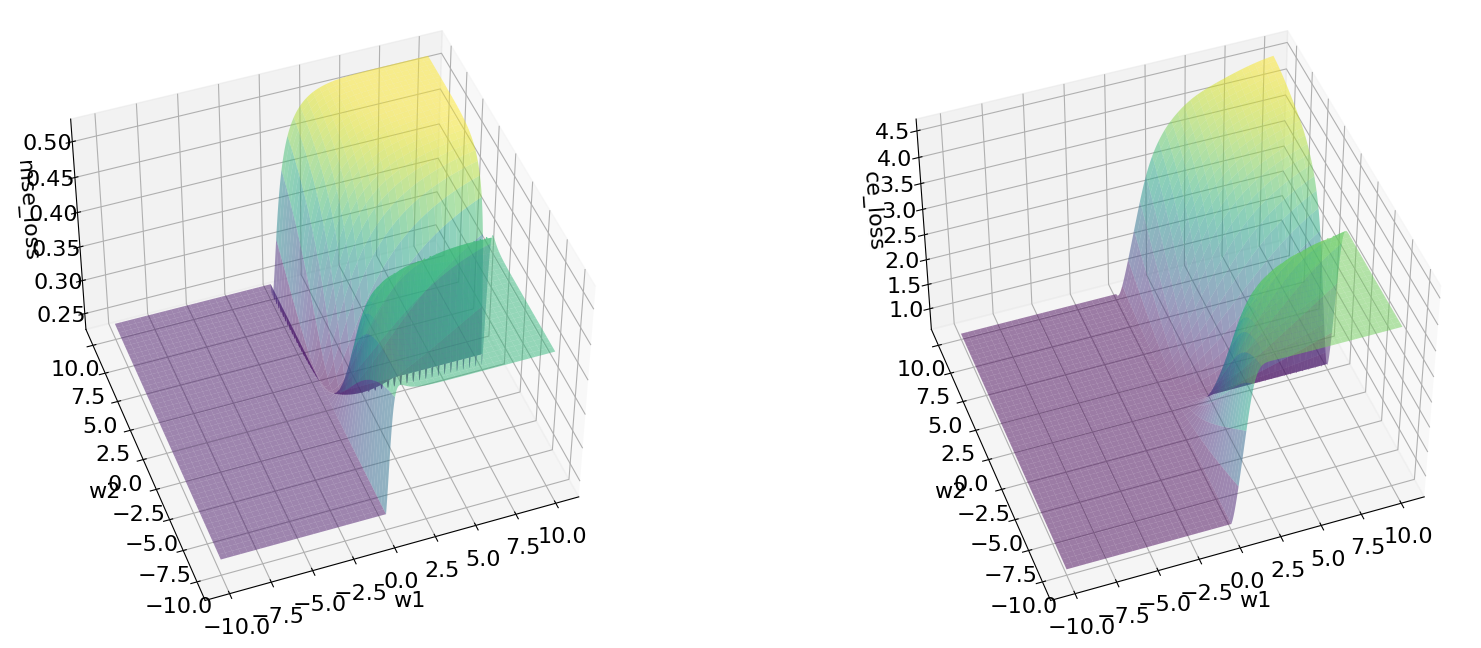

In [13]:
w1 = np.arange(-10, 10, 0.01).reshape(1, 2000)
w2 = np.arange(-10, 10, 0.01).reshape(1, 2000)

model = TwoParameterNN(act=relu)
y_hat = sigmoid(model(w1, w2, x))
print(y_hat.shape)

# plot the surface
mse_curve = np.mean(mse_loss(y_hat, y), axis=0).transpose()
ce_curve = np.mean(ce_loss(y_hat, y), axis = 0).transpose()

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')

W1, W2 = np.meshgrid(w1.squeeze(), w2.squeeze())

ax1.plot_surface(W1, W2, mse_curve, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("mse_loss")
ax1.view_init(45, -110)

ax2.plot_surface(W1, W2, ce_curve, cmap='viridis', alpha = 0.5)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("ce_loss")
ax2.view_init(45, -110)

plt.show()


**Sigmoid**

(10, 2000, 2000)


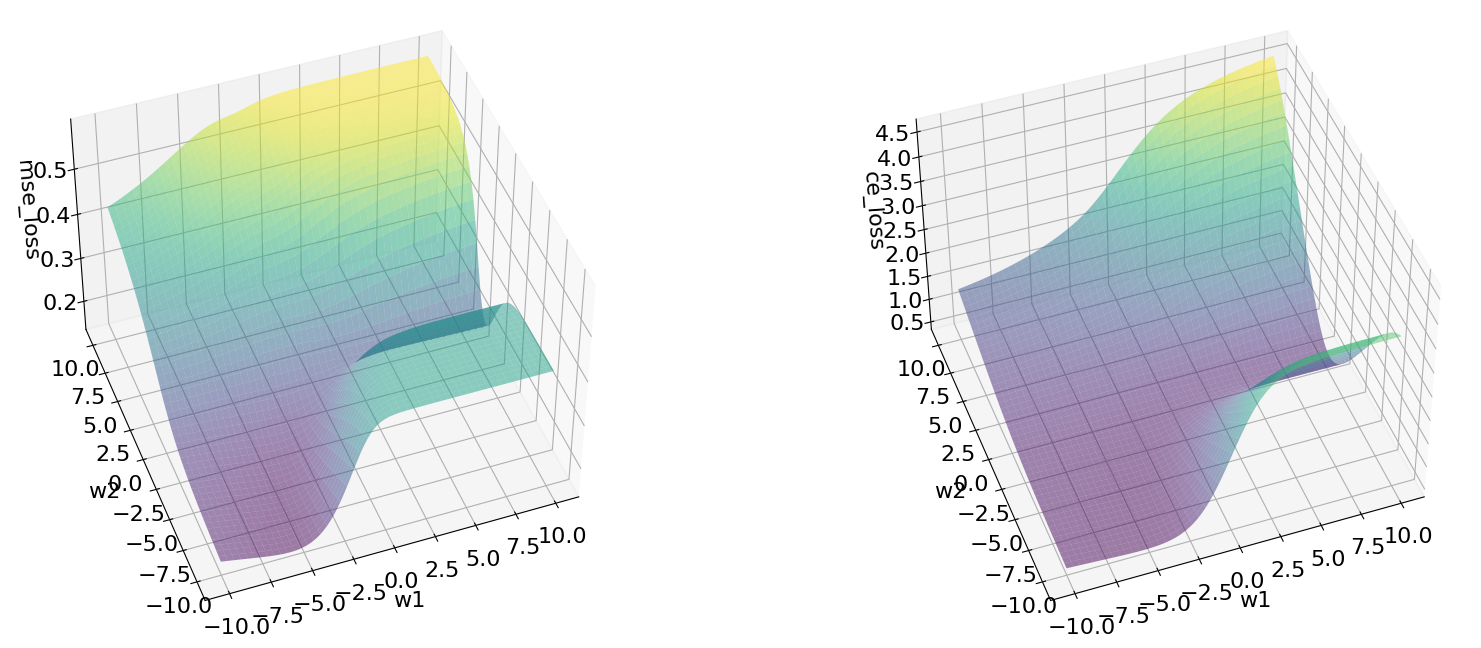

In [14]:
w1 = np.arange(-10, 10, 0.01).reshape(1, 2000)
w2 = np.arange(-10, 10, 0.01).reshape(1, 2000)

model = TwoParameterNN(act=sigmoid)
y_hat = sigmoid(model(w1, w2, x))
print(y_hat.shape)

# plot the surface
mse_curve = np.mean(mse_loss(y_hat, y), axis=0).transpose()
ce_curve = np.mean(ce_loss(y_hat, y), axis = 0).transpose()

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')

W1, W2 = np.meshgrid(w1.squeeze(), w2.squeeze())

ax1.plot_surface(W1, W2, mse_curve, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("mse_loss")
ax1.view_init(45, -110)

ax2.plot_surface(W1, W2, ce_curve, cmap='viridis', alpha = 0.5)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("ce_loss")
ax2.view_init(45, -110)

plt.show()


**Tanh**

(10, 2000, 2000)


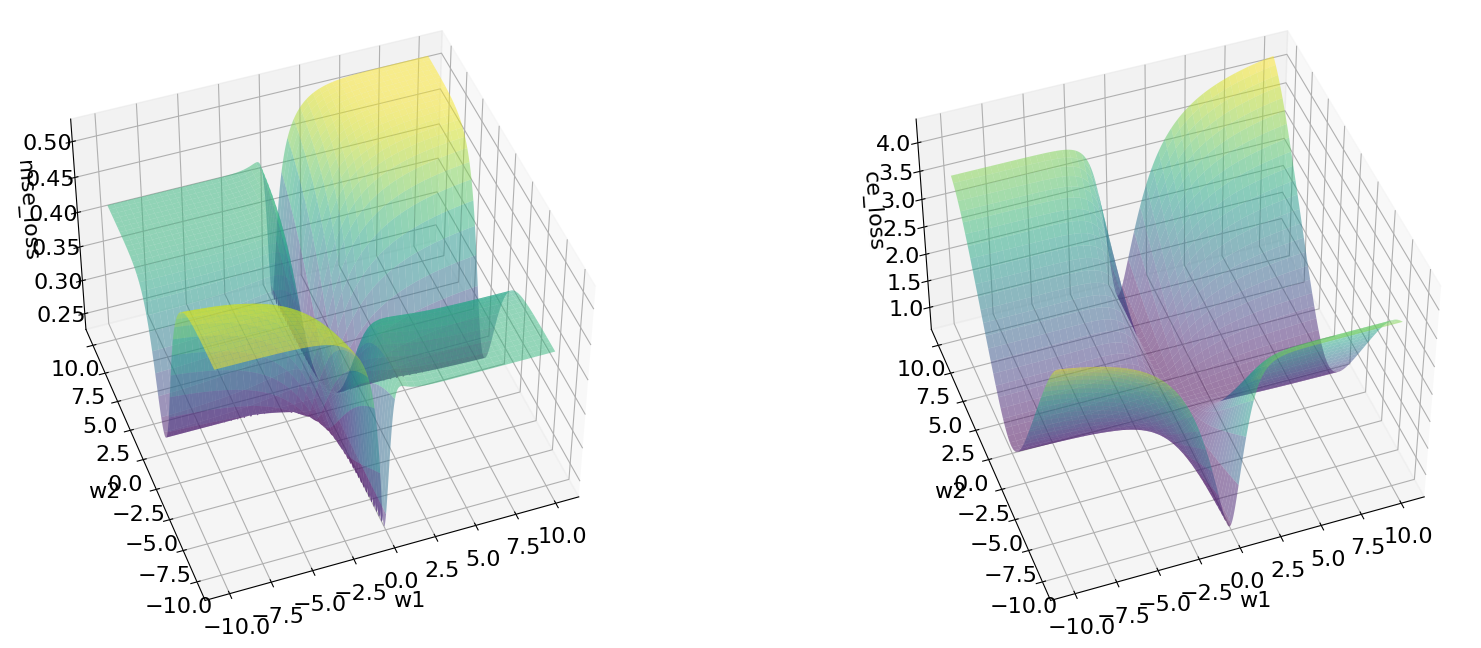

In [15]:
w1 = np.arange(-10, 10, 0.01).reshape(1, 2000)
w2 = np.arange(-10, 10, 0.01).reshape(1, 2000)

model = TwoParameterNN(act=np.tanh)
y_hat = sigmoid(model(w1, w2, x))
print(y_hat.shape)

# plot the surface
mse_curve = np.mean(mse_loss(y_hat, y), axis=0).transpose()
ce_curve = np.mean(ce_loss(y_hat, y), axis = 0).transpose()

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')

W1, W2 = np.meshgrid(w1.squeeze(), w2.squeeze())

ax1.plot_surface(W1, W2, mse_curve, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("mse_loss")
ax1.view_init(45, -110)

ax2.plot_surface(W1, W2, ce_curve, cmap='viridis', alpha = 0.5)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("ce_loss")
ax2.view_init(45, -110)

plt.show()

## NOTE

**All the networks without bias term actually cannot learn the to solve this problem. Why ?**

### Tracking the loss curve on optimization manifold

In [16]:
import torch

class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.l1 = torch.nn.Linear(1,1, bias = True)
    self.reset_parameters()

  def reset_parameters(self):
    torch.nn.init.constant_(self.l1.weight, -2)
    torch.nn.init.constant_(self.l1.bias, 4)

  def forward(self, x):
    y_hat = torch.sigmoid(self.l1(x))
    return y_hat


In [17]:
w = np.arange(-5, 5, 0.01).reshape(1, 1000)
b = np.arange(-5, 5, 0.01)

model = AffineLayer()
y_hat = sigmoid(model(w, b, x))

ce_curve = np.mean(ce_loss(y_hat, y), axis = 0).transpose()
W, B = np.meshgrid(w.squeeze(), b.squeeze())


def live_plot(_w, _b, loss, acc, color="black"):
  clear_output(wait=True)
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(111,projection='3d')
  ax1.plot_surface(W, B, ce_curve, cmap='viridis', alpha = 0.5)
  ax1.set_xlabel("Weight")
  ax1.set_ylabel("Bias")
  ax1.set_zlabel("ce_loss")


  #_w, _b = np.meshgrid(_w, _b)
  ax1.plot(_w, _b, loss, marker = "s", color = color)
  ax1.set_title("acc : {}".format(acc))
  ax1.view_init(45, -110)
  plt.show()



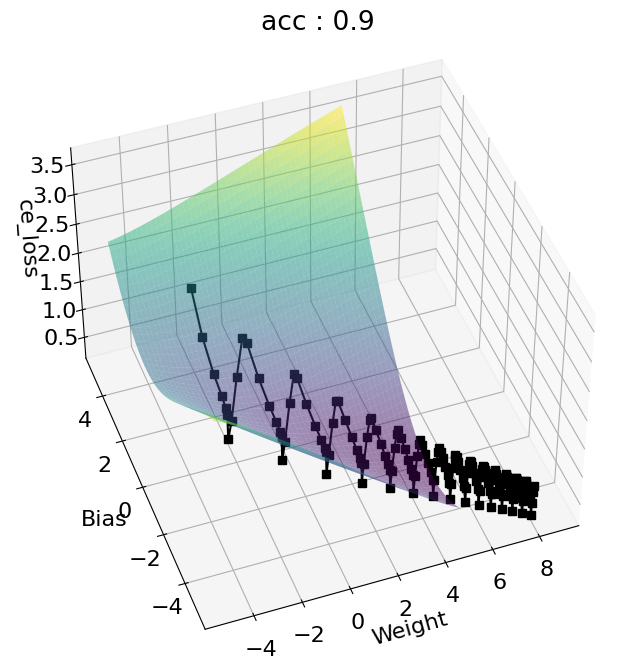

In [ ]:
model = NeuralNetwork()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1, momentum = 0.3)
data = torch.arange(0, 1, 0.1).reshape(10, 1)
batch_size = 1
label = data.round()
w_list = []
b_list = []
loss_list = []
acc = 0
for epoch in range(100):
  idx = 0
  while idx < data.shape[0]:
    batch_x = data[idx : idx+batch_size]
    batch_y = label[idx : idx + batch_size]

    logits = model(batch_x)
    loss = loss_fn(logits, batch_y)
    #acc = torch.mean((logits.round() == batch_y).type(torch.float))
    #print(loss, acc)

    w, b = [p.detach().item() for p in model.parameters()]
    w_list.append(w)
    b_list.append(b)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      _logits = model(data)
      _loss = loss_fn(_logits, label)
      loss_list.append(_loss.detach().item())
      acc = torch.mean((_logits.round() == label).type(torch.float)).detach().item()
      acc = round(acc, 4)


    live_plot(w_list, b_list, loss_list, acc)
    idx += batch_size

  if acc == 1:
    break



**Most Optimization manifolds in Deep Learning are steap hills and long valleys**

### TODO
1) Create a validation set and visualize overfitting \\
2) Play around with different effects of batch size, learning rate and momentum